In [143]:
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import geopandas as gpd

%matplotlib inline
DATA_FILE = 'uber-pickups-in-new-york-city/uber-raw-data-aug14.csv'

uber_data = pd.read_csv(DATA_FILE)

uber_data['Date/Time'] = pd.to_datetime(uber_data['Date/Time'], format="%m/%d/%Y %H:%M:%S")
uber_data['DayOfWeekNum'] = uber_data['Date/Time'].dt.dayofweek
uber_data['DayOfWeek'] = uber_data['Date/Time'].dt.weekday_name
uber_data['MonthDayNum'] = uber_data['Date/Time'].dt.day
uber_data['HourOfDay'] = uber_data['Date/Time'].dt.hour
uber_data['ChunkIndex'] = 4*uber_data['HourOfDay'] + uber_data['Date/Time'].dt.minute // 15 # which 15-minute block within the day is it in

uber_data.head()
#829275 entries

,Date/Time,Lat,Lon,Base,DayOfWeekNum,DayOfWeek,MonthDayNum,HourOfDay,ChunkIndex
0,2014-08-01 00:03:00,40.7366,-73.9906,B02512,4,Friday,1,0,0
1,2014-08-01 00:09:00,40.7260,-73.9918,B02512,4,Friday,1,0,0
2,2014-08-01 00:12:00,40.7209,-74.0507,B02512,4,Friday,1,0,0
3,2014-08-01 00:12:00,40.7387,-73.9856,B02512,4,Friday,1,0,0
4,2014-08-01 00:12:00,40.7323,-74.0077,B02512,4,Friday,1,0,0


In [144]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829275 entries, 0 to 829274
Data columns (total 9 columns):
Date/Time       829275 non-null datetime64[ns]
Lat             829275 non-null float64
Lon             829275 non-null float64
Base            829275 non-null object
DayOfWeekNum    829275 non-null int64
DayOfWeek       829275 non-null object
MonthDayNum     829275 non-null int64
HourOfDay       829275 non-null int64
ChunkIndex      829275 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 56.9+ MB


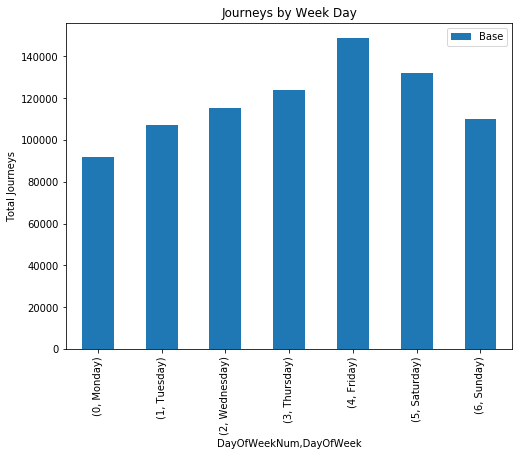

In [145]:
uber_weekdays = uber_data.pivot_table(index=['DayOfWeekNum', 'DayOfWeek'],
                                  values='Base',
                                  aggfunc='count')
uber_weekdays.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Journeys')
plt.title('Journeys by Week Day');

In [47]:
# Not displaying anything for now

# gdf = gpd.GeoDataFrame(
#     uber_data, geometry=gpd.points_from_xy(uber_data.Lon, uber_data.Lat))
# # gdf.head()

# gdf.crs = {'init': 'epsg:4326'}
# print(gdf.head())

# gdf = gdf.to_crs({'init': 'epsg:3395'})
# print(gdf.head())



In [146]:
from haversine import haversine

# x is lat space, y is lon space
min_lat, min_lon = min(uber_data['Lat']), min(uber_data['Lon'])
max_lat, max_lon = max(uber_data['Lat']), max(uber_data['Lon'])

max_x_dist = haversine((min_lat, min_lon), (max_lat, min_lon))
max_y_dist = haversine((min_lat, min_lon), (min_lat, max_lon))

x_nums, y_nums = 1000, 1000 # of cells in each axis
x_cell_size = max_x_dist / x_nums # in km
y_cell_size = max_y_dist / y_nums # in km

def cluster_coordinate(lat, lon):
    x_dist = haversine((min_lat, min_lon), (lat, min_lon))# dist along lat
    y_dist = haversine((min_lat, min_lon), (min_lat, lon))# dist along lon
    
    return x_dist // x_cell_size, y_dist // y_cell_size


# print(min_lat, max_lat)
# print(min_lon, max_lon)
# print()
# cluster_coordinate(40.7366, -73.9906)

# uber_data.head()
# 

In [193]:
# add cluster coordinates to all entries in uber data
uber_data['ClusterCoordinateX'] = uber_data.apply(lambda row: int(cluster_coordinate(row['Lat'], row['Lon'])[0]), axis=1)
uber_data['ClusterCoordinateY'] = uber_data.apply(lambda row: int(cluster_coordinate(row['Lat'], row['Lon'])[1]), axis=1)


In [222]:
# TESTS

# uber_data[uber_data['ClusterCoordinateX'] == 594][uber_data['ClusterCoordinateY']==406]

In [258]:

# count rides per 15-minute chunk for each (chunkindex, monthdaynum, dayofweeknum, coordX, coordY) as key
uber_rides_count = uber_data.pivot_table(index=[ 'ClusterCoordinateX', 'ClusterCoordinateY', 'DayOfWeekNum', 'MonthDayNum', 'ChunkIndex'],
                                  values='Base',
                                  aggfunc='count')
uber_rides_count.head()


,,,,,Base
ClusterCoordinateX,ClusterCoordinateY,DayOfWeekNum,MonthDayNum,ChunkIndex,
0,224,4,1,78,1
7,251,5,23,54,1
158,271,5,23,92,1
169,287,6,31,6,1
173,261,3,14,77,1


In [259]:
# START TRAINING STUFF HERE

# write uber data to output file
TRAIN_FILE = 'training.csv'
uber_rides_count.to_csv(TRAIN_FILE)

In [267]:
# NOW START TRAINING ---------------
dataset = pd.read_csv(TRAIN_FILE)
dataset.head()

,ClusterCoordinateX,ClusterCoordinateY,DayOfWeekNum,MonthDayNum,ChunkIndex,Base
0,0,224,4,1,78,1
1,7,251,5,23,54,1
2,158,271,5,23,92,1
3,169,287,6,31,6,1
4,173,261,3,14,77,1


In [268]:
dataset.loc[train_data['Base'].idxmax()]
# this ends up being JFK airport which seems accurate

ClusterCoordinateX    594
ClusterCoordinateY    406
DayOfWeekNum            0
MonthDayNum             4
ChunkIndex             21
Base                   30
Name: 12525, dtype: int64

In [269]:
# stats for 15-minute increments
print('Min rides: {}, max rides: {}'.format(min(dataset['Base']), max(dataset['Base'])))
print('Average rides: {}'.format(dataset['Base'].mean()))
print('stddev rides: {}'.format(dataset['Base'].std()))

Min rides: 1, max rides: 30
Average rides: 1.264152208941254
stddev rides: 0.7060573772139869


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0


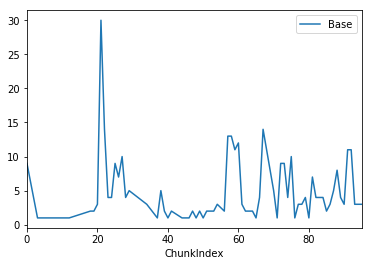

In [304]:
example_test = dataset[dataset['ClusterCoordinateX']==594][dataset['ClusterCoordinateY']==406][dataset['DayOfWeekNum']==0][dataset['MonthDayNum']==4].sort_values(by=['ChunkIndex'])
example_test.plot(x='ChunkIndex', y='Base')



In [297]:
# TRAINING STARTS

import numpy as np
from sklearn.ensemble import RandomForestClassifier

# split dataset into (train, test)
# For now, splitting on all data tuples, not separating based on cluster
def split(dataset, train_fraction):
    msk = np.random.rand(len(dataset)) < train_fraction
    return dataset[msk], dataset[~msk]

train, test = split(dataset, .8)
features = dataset.columns[:5] # coordX, coordY, dayofweeknum, monthdaynum, chunkindex


clf = RandomForestClassifier(n_estimators=20)
clf.fit(train[features], train['Base'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [298]:
pred = clf.predict(test[features])
expect = test['Base']
confusion = pd.crosstab(expect, pred, rownames=['Actual'], colnames=['Predicted'])

confusion

# print(list(zip(train[features], clf.feature_importances_)))

Predicted,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,19,21,23,30
Actual,,,,,,,,,,,,,,,,,,,,
1,101426,4644,783,207,84,15,14,7,1,0,0,0,0,0,0,0,0,0,0,0
2,15148,1804,459,147,67,32,10,6,4,2,2,0,2,0,1,0,0,0,0,0
3,3141,686,246,107,47,14,9,10,7,2,1,1,1,0,0,1,0,0,0,0
4,787,271,125,60,37,20,6,12,4,3,1,0,0,0,0,0,0,0,0,0
5,235,96,50,34,20,18,7,6,2,1,0,1,0,0,0,0,0,0,0,0
6,56,55,32,21,11,9,4,3,0,0,0,1,0,0,0,1,0,0,0,0
7,34,23,19,11,10,1,1,6,3,2,0,0,1,0,1,0,0,0,0,0
8,11,11,6,3,5,6,3,7,0,0,1,0,0,0,1,0,0,0,0,0
9,8,8,3,4,3,6,2,6,2,1,0,1,0,0,0,0,0,0,0,0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


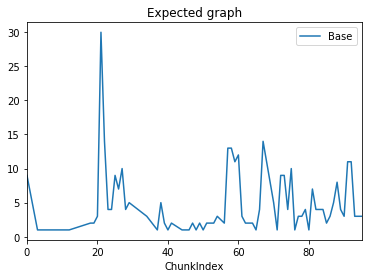

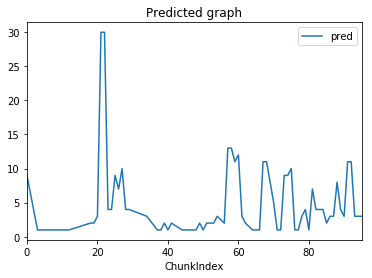

In [344]:
# example of running the model
# coordX, coordY, dayofweeknum, monthdaynum, chunkindex

# plot predicted nums, and true nums for each chunkindex

# ClusterCoordinateX	ClusterCoordinateY	DayOfWeekNum	MonthDayNum	ChunkIndex	Base
def visualize(coordx, coordy, dayofweeknum, monthdaynum):
    
    expect = dataset[dataset['ClusterCoordinateX']==coordx][dataset['ClusterCoordinateY']==coordy][dataset['DayOfWeekNum']==dayofweeknum][dataset['MonthDayNum']==monthdaynum].sort_values(by=['ChunkIndex'])
    if expect.empty:
        return
    test_data = np.zeros((len(expect), 5))
    
    test_data[:, 0] = len(expect)*[coordx]
    test_data[:, 1] = len(expect)*[coordy]
    test_data[:, 2] = len(expect)*[dayofweeknum]
    test_data[:, 3] = len(expect)*[monthdaynum]
    test_data[:, 4] = expect['ChunkIndex']
    pred = clf.predict(test_data)
    expect['pred'] = pred
    
    expect.plot(x='ChunkIndex', y='Base', title='Expected graph')
    expect.plot(x='ChunkIndex', y='pred', title='Predicted graph')
    

visualize(594, 406, 0, 4)
#visualize(662, 317, 0, 18)
# visualize(653, 315, 3, 21)
#visualize(672, 369, 6, 17)